## Classification
In this notebook, I am going to learn how to make a machine learning model that can classify
hand-written numbers. For learning purposes, I am only going to loosely follow his instructions
and just try to apply the general principles, develop a better sense of what is really
going on than from the previous example

# The Data
I am going to use the MNIST dataset, 70,000 small images of digits hand-written
by high school students and US Census Bureau employees.
This dataset is such a popular one that SciKit-Learn has specific methods to fetch it.

In [2]:
# using A.G.'s code to "make the images prettier"
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# get the data, need pandas for the import as per scikit-learn
from sklearn.datasets import fetch_openml
import pandas
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto') # parser=auto is needed to silence future warnings
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### SciKit Learn dataset features
SciKit Learn datasets have common features, some seen in the keys above, that include:
* DESCR key describes the dataset
* data key has an array with one row per instance and one column per feature
* target key has an array with the labels

In [4]:
# show the specifics of the above in this dataset
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

the data key has 70,000 images with 784 features each. 784 is total pixel count for each image (28 x 28).
Each feature is thus one pixel, and the pixel can have a value from 0 to 255 (white to black).
Below we will display one image from the key:

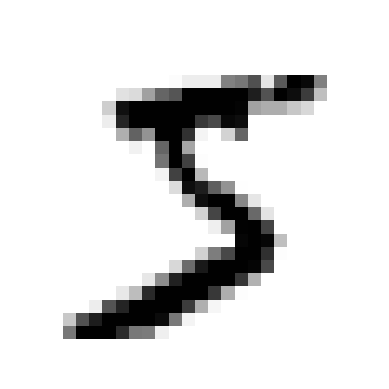

In [6]:
# we will use Matplotlib's imshow() function
import matplotlib as mpl
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) # reshape function transforms 784 values into 28 x 28 matrix
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

There, it looks like a 5 (it is a 5). Now let's check the label:

In [7]:
y[0] # note this is a string, might have to cast these to integers later

'5'

In [8]:
# now build the test and train sets, one of each for data and label keys
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# we don't have to shuffle the sets because they came this way from Scikit-Learn

# Make and train a binary classifier
For the purposes of learning in the sense of crawl, walk, run, we will create a binary classifier
that will learn how to distinguish 5 from everything else. Later, we will make a multi-classifier
that can learn all the other digits.
Géron recommends using a _Stochastic Gradient Descent_ classifier, which efficiently handles
large datasets.
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [9]:
# need to create specific label set that has only the value of 5 - don't forget it's a string!
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
from sklearn.linear_model import SGDClassifier

# create the classifier object and fit to training data
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
# now let's use it to see if it can correctly guess that some digit variable we made above is 5
sgd_clf.predict([some_digit])

array([ True])

It worked!

## Develop and execute performance measures
It's difficult to evaluate a classifier compared to a regressor, so there are a multiple of methods to learn.
First we use:
### Cross-Validation
We use the cross_val_score() method from SciKit-Learn, uses K-fold cross-validation, splitting the training set
into K number of folds. We will use 3. Each fold is evaluated using a model trained on the remaining folds.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

.> 95% accuracy! But is this good? Now we use a 'dumb' classifier to class all the not-5's:

In [12]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That's pretty good too, but it's just playing the odds; only 10% of the data set are 5's.
So the measurement given by cross-validation in this task doesn't really get us anywhere, and we
need to look at other methods.

### Confusion matrix
The idea is to count the number of times instances of class A are classified as class B.
You need a set of predictions to compare against actual targets. We can get these predictions
from cross_val_predict, then use the confusion matrix.

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Let's interpret this matrix. Row 1 encodes the non-5 images, the negative class: **53,892 correctly
classified, 687 incorrectly classified.** Row 2 encodes the 5 images, the positive class: **1891
incorrectly classified, 3530 correctly classified.**
How does this compare with a perfect confusion matrix, i.e. no false positives? Let's build one and compare:

In [14]:
# create perfect matrix
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

We need to measure what these confusion matrices really say, so we will look at two metrics, precision and recall.
precision = $\frac{TP}{TP + FP}$ where TP is true positives and FP is false positives
recall = $\frac{TP}{TP + FN}$ where FN is false negatives

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

These can be combined into a single metric called the F score, it is the harmonic mean of precision and recall.
Which weights low values higher, so the classifier will only get a high F score if both recall and precision are high.

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### The Problem will Precision versus Recall
These two metrics are 'entangled' somewhat in that if you work to increase one, it will come at the expense of the other. Too high of a precision score will entail a reduced recall score. In the following code snippets we will look at how the decision score - the threshold the binary classifier uses to decide - can be altered and what effects it will have on precision vs recall and find a way to a classifier with relatively high precision and recall.

In [18]:
# we will call the classifier's decision function instead of predict method
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Clearly jacking the threshold up to an absurd value decreases recall. To find the optimal threshold value, we will use cross_val_predict but we want to return decision scores instead of predictions. Then we will plot the precision and recall curves as functions of threshold against each other.

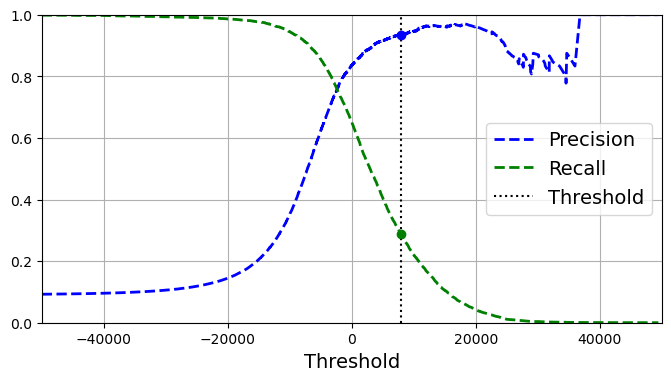

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='Threshold')

# extra code to prettify the graph
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.savefig("precision_recall_vs_threshold_plot")

plt.show()

We can also plot precision directly against recall to analyze the trade-offs.

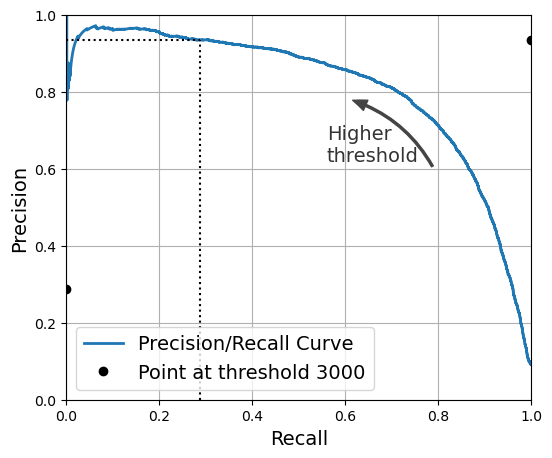

In [25]:
# we will add some code to superimpose an arrow and text onto the plot to better explain it
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall Curve')

import matplotlib.patches as patches
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx], precisions[idx]], "ko", label='Point at threshold 3000')
plt.gca().add_patch(patches.FancyArrowPatch((0.79, 0.60), (0.61, 0.78), connectionstyle="arc3,rad=.2",
                                            arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
                                            color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.savefig("precision_vs_recall_plot")

plt.show()

From the graph we see that precision drops off sharply around 80% recall. A good precision/recall would just before this drop, around 60% recall. Selected value will depend on a project's goal, however.

Let's aim for 90% precision by way of example. According to the first plot, that's around a threshold of 8000. We can find the lowest threshold that gives at least 90% precision with np.argmax().

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

As we can see here, 90% precision comes at a price of 48% recall.

### The Receiver Operating Characteristic (ROC) Curve
This curve is commonly used with binary classifiers; instead of plotting precision versus recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the _true negative rate_ (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called _specificity_. The ROC plots _sensitivity_ (recall) versus 1 - _specificity_. Let's plot it.

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

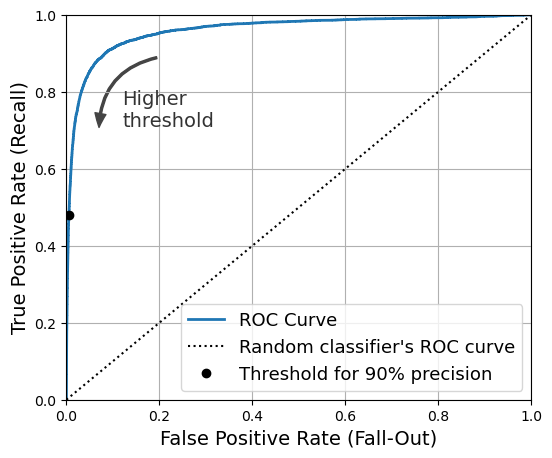

In [32]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0,1], [0,1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# once again we are adding in the fancy arrow to help explain the plot
plt.gca().add_patch(patches.FancyArrowPatch((0.20, 0.89), (0.07, 0.70), connectionstyle="arc3,rad=.4",
                                            arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
                                            color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.savefig("roc_curve_plot")

plt.show()

ROC curves can be used to compare the effectiveness of different classifiers by computing the area under the curve (AUC) for each classifier and then comparing them. A theoretically-perfect classifier would have an ROC AUC of 1.0, while a purely random classifier would have an ROC AUC of 0.5. We have been using a stochastic gradient descent (SGD) classifier in these examples, now we will train a random forest classifier, and then compare the two using ROC AUC.

In [33]:
# create and train the random forest classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [34]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [35]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [36]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

Now we will plot precision vs recall curves for SGDClassifier and RandomForestClassifier:

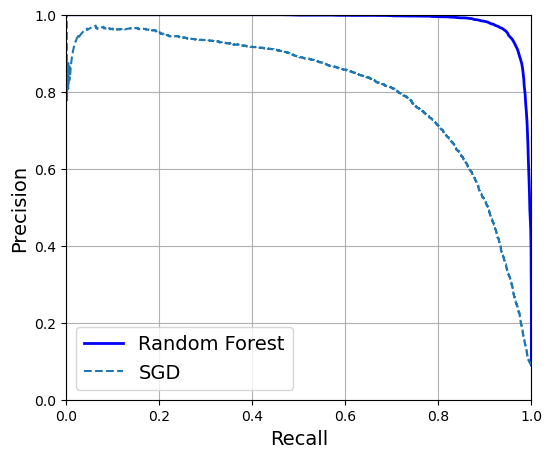

In [37]:
plt.figure(figsize=(6,5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", label="SGD")

# prettify
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.savefig("pr_curve_comparison_plot")

plt.show()

Just by visual inspection of the curves, the Random Forest classifier is markedly superior here to the Stochastic Gradient Descent Classifier. For specific metrics:

In [38]:
# roc auc scores
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [39]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [43]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [44]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [47]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

At 99% precision, 87% recall, Random Forest is much superior SGD at 84% precision, 65% recall.

## Multiclass classification
Binary classifiers can distinguish between two classes, in the above example, "5" and "not 5"; multiclass (or multinomial) classifiers can distinguish between many classes. Not all classifiers can handle multiclassification; logistic regression and SVM are binary-only.
### Multiclass strategies
* __One versus the Rest (OvR)__: you establish _n_ classes, and then sequentially classify _n<sub>1</sub>_ | _not n<sub>1</sub>_ and then on to _n<sub>2</sub>_ and so on
* __One versus One (OvO)__: you train a binary classifier on every pair of digits within the set size of _n_. For this dataset (MNIST), we have ten digits we wish to classify with equates to 45 binary classifiers! $n \times \frac{(n - 1)}{2}$ the advantage to OvO is that each classifier must be trained only on part of the training set.
* OvO is good for classifiers that scale poorly with the size of the training set, like an SVM. But for most OvR is preferred.

SciKit-Learn detects when you use a binary classifier for a multiclass classification task, and will automatically run OvO or OvR depending on the algorithm. Let's try it with a SVM:

In [49]:
# SVMs don't do well with large datasets so here we will be using the first 2000 instances
from sklearn.svm import SVC # support vector machine classifier

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [51]:
svm_clf.predict([some_digit]) # calling the classifier to decide what digit the some_digit image is

array(['5'], dtype=object)

Note that we used the training data for 0-9, not just 5. So the SVC evaluated the target image against all image types and in this case correctly chose the result. SVC here used the OvO strategy, we can call the decision_function method and see the decision scores for each different kind of digit:

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

SciKit-Learn can be forced to select OvR or OvO as one wishes, but I am not going to bother with it as he did in the book.

## Error Analysis
As part of the process of developing a machine learning project, once a promising model has been selected, we need to determine how we can improve it, and to do this we need to analyze the types of errors it makes.
We will start with the confusion matrix, but use a SciKit-Learn function that visualizes it:

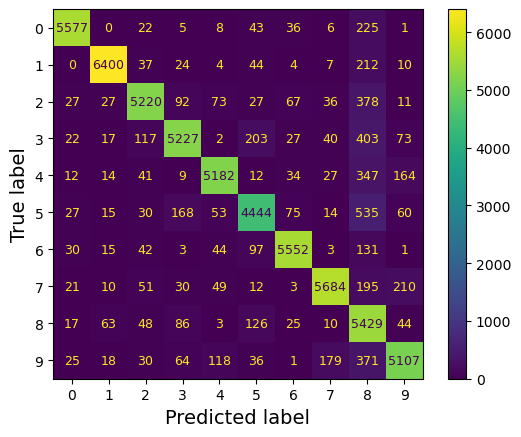

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

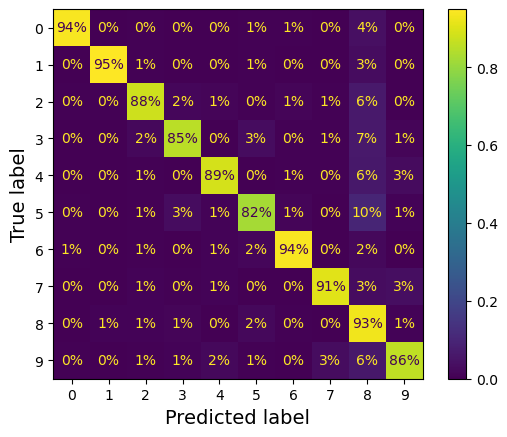

In [55]:
# we will normalize the above table and get percentages
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%")

plt.show()

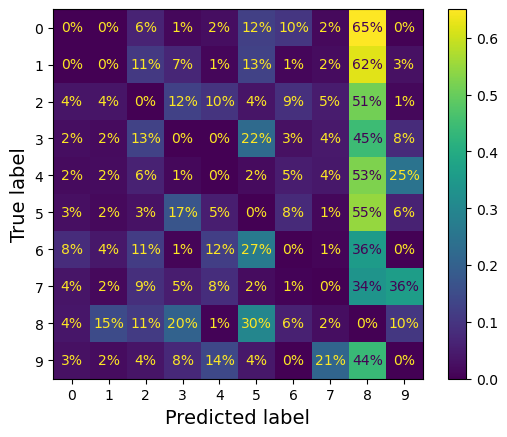

In [56]:
# now finally to highlight on where errors are being made
sample_weight = (y_train_pred != y_train) # everywhere predictions don't match truth
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight,
                                        normalize='true',values_format=".0%")

plt.show()

From this table, we can clearly see that there are problems with recognizing 8 as a digit - 8's in the data are being frequently confused for other digits. There's also a lesser issue with 3's and 5's. This makes intuitive sense. This analysis could guide us to remediate this problem possibly by increasing the training set with more digits that are not 8 but are frequently mistaken for it, so the classifier could learn better how to distinguish them. Or the algorithm could be modified to make it better at distinguishing 8's, perhaps by counting loops in the figure.

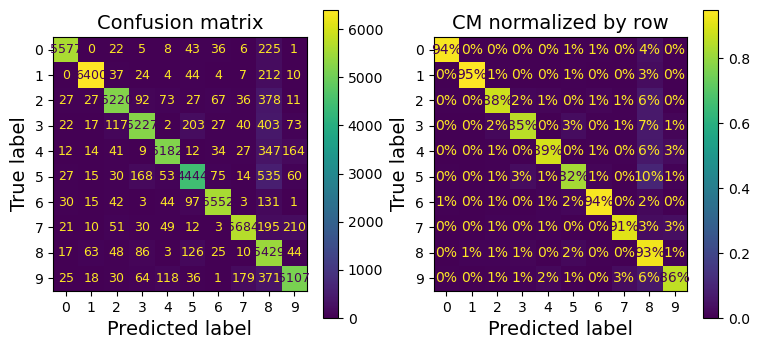

In [57]:
# gather the plots and save them as figures
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
plt.savefig("confusion_matrix_plot_1")
plt.show()

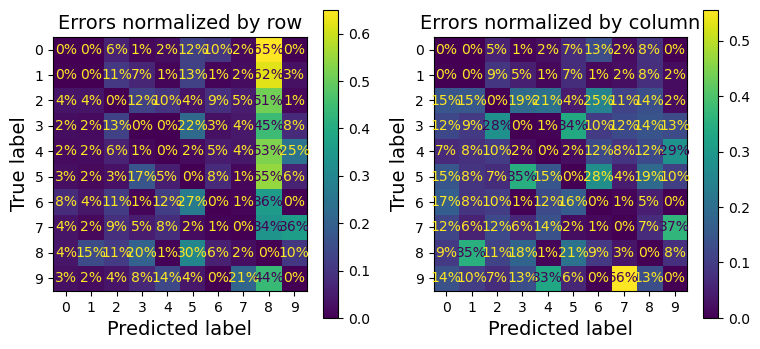

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
plt.savefig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

Finally, we can look at the digits where mistakes were made and perhaps get an idea of why the classifier was making mistakes. We will look at 5's and 3's getting mistaken for each other:

In [59]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # true = 3, predicted = 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # true = 3, predicted = 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # true = 5, predicted = 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # true = 5, predicted = 5

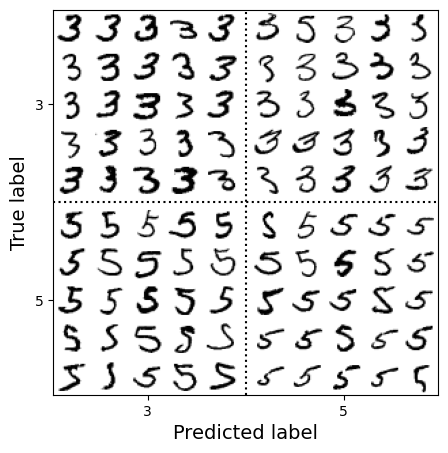

In [60]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("error_analysis_digits_plot")

plt.show()

Some of the figures are easily mistaken even to the unaided eye!

## Multilabel and Multi-output Classification
### Multilabel classification
So far we have assigned each instance to a single class, however sometimes it is necessary to assign multiple classes to each instance. Below is a simple example (more complex example is face recognition, which we will cover in another notebook):

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

Correctly labeling "some digit" which is 5 as False, not greater than 7, and true as odd number.
According to the book, many ways to evaluate a multilabel classifier; one way is to compute the F<sub>1</sub> score for each label, then average all the F<sub>1</sub> scores.

In [64]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### Multi-output Classification
This is a generalization of multilabel classification where each label can be multiclass. The example here is we will build a system that removes noise from images.
First step is to create the noisy images - we will create training and test sets from MNIST and add noise to their pixel intensities with NumPy's randint() function. Target images will be the original images.

In [67]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

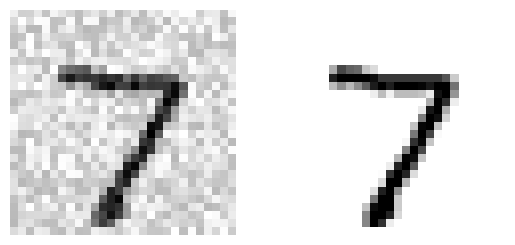

In [68]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.savefig("noisy_digit_example_plot")

plt.show()

Now let's clean it up!

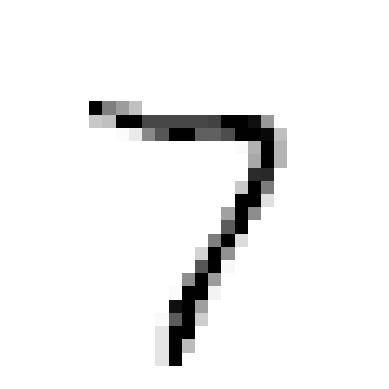

In [70]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.savefig("cleaned_digit_example_plot")

plt.show()

Good work!
### Summary
We should now know:
* how to select good metrics for classification tasks
* pick the appropriate precision/recall trade-off
* compare classifiers
* more generally, build good classification systems for a variety of tasks